In [1]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler
plt.style.use('seaborn-whitegrid')

# PSS Score

In [2]:
def get_threshold(scores):
    scores = np.array(scores)
    lower_threshold = scores.mean() - (scores.std()/2)
    upper_threshold = scores.mean() + (scores.std()/2)
    return scores.mean(), (lower_threshold,upper_threshold)

def get_stress_type(score, grade):
    """ Non-stress (0): score < lower_threshold
        Neutral    (1): lower_threshold <= score <= upper_threshold
        Stress     (2): score > lower_threshold """
    if(score < grade[0]):
        return 0
    elif(score <= grade[1]):
        return 1
    elif(score > grade[1]):
        return 2

def PSS_printer(PSS):
    # peak at info
    temp = PSS.popitem()
    PSS[temp[0]] = temp[1]
    column = list(temp[1].keys())
    space = "\t\t"
    print(f"Name{space}",f"{space}".join(column),sep="" )
    print("="*60)
    for name, info in PSS.items():
        print(f"{name}{space}",sep="",end="")
        for col in column:
            print(f"{info[col]}{space}",end="")

        print()

def get_PSS():
    try:
        PSS = load('PSS_cut')
        type_count = load('type_count_cut')
        return PSS, type_count
    except:
        PSS = dict()
        scores = []
        with open('./PSS_scores_cut.csv','r') as f:
            f.readline() # skip header
            for line in f.readlines(): 
                name,score = line.split(',')
                PSS[name] = {'score':int(score)}
                scores.append(int(score))

        mean, grade = get_threshold(scores)
        print(f"Total={len(PSS)} | Mean={mean} | Lower Thres={grade[0]} | Higher Thres={grade[1]}")

        type_count = {0:0, 1:0, 2:0}
        for name, dict_info in PSS.items():
            label = get_stress_type(dict_info['score'], grade)
            dict_info['type'] = label
            dict_info['type_definition'] = TYPE_DEF[label]
            type_count[label] = type_count[label] + 1

        # print(f"Non Stress={type_count[0]} | Neutral={type_count[1]} | Stress={type_count[2]}")

        # PSS_printer(PSS)

        sampling_rate = 125 #Hz
        files = glob(f"data/*.csv")
        for index, f in enumerate(files):
            name = f.split('/')[1].split('__')[0]
            if(name in PSS.keys()):
                pd_raw = pd.read_csv(f, dtype={'Marker':str})
                pd_raw = pd_raw.drop(columns='timestamps')
                raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
                PSS[name]['raw'] = raw
                print(f"{index} {name} | time: {len(pd_raw)/125}")
            # else:
            #     print(name)

        save(PSS, 'PSS_cut')
        save(type_count, 'type_count_cut')
        return PSS, type_count
    # finally:

TYPE_DEF = {0:'Non-Stress', 1:'Neutral', 2: 'Stress'}
PSS, type_count = get_PSS()

In [3]:
def get_freq(PSS):
    # peak at info
    temp = PSS.popitem()
    PSS[temp[0]] = temp[1]
    raw = temp[1]['raw']
    power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)
    return freq


for name, info in PSS.items():
    raw = info['raw']
    raw.filter(l_freq=1,h_freq=None, method='iir', iir_params={'order':3.0, 'ftype':'butter'}, verbose=False) # Slow drift
    raw.notch_filter(freqs=[50])
    # epochs = mne.Epochs(raw, np.array([[125*60*1, 0, 1]]), tmin=0, tmax=30, baseline=(0,30), verbose=False)
    # print(name)

    # a = epochs.plot_psd(picks=['F3','F4','T3','T4'])
    # print("="*40)


freq = get_freq(PSS)
print(freq)


band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

Effective window size : 1.000 (s)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


/tmp/ipykernel_7504/1690261624.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [4]:
def get_markers():
    sampling_rate = 125 #Hz
    step_minutes = np.arange(0,5,0.25)
    print(f"{step_minutes=}")
    step_minutes = np.expand_dims(step_minutes * sampling_rate * 60, axis=1)
    markers = np.concatenate( [step_minutes, np.zeros( step_minutes.shape ), np.ones( step_minutes.shape ) ], axis=1  ).astype(np.int64)
    return markers
markers = get_markers()
markers.shape

step_minutes=array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])


(20, 3)

# CSP with 3rd library

In [5]:
task_non_stress = []
task_stress = []
for name,info in PSS.items():
    # skips Normal
    if(info['type'] == 1): continue

    raw = info['raw']
    epochs = mne.Epochs(raw, markers, tmin=0, tmax=15, baseline=(0,15), verbose=False)
    for evoked in epochs.iter_evoked():
        # print(evoked.data.shape)
        # print(evoked.data[:16,:])
        if(info['type'] == 0): task_non_stress.append(evoked.data[:16,:])
        elif(info['type'] == 2): task_stress.append(evoked.data[:16,:])

from CSP import *
from utils import *
csp_filter = CSP(task_non_stress, task_stress)
save(csp_filter,'csp_filter')

/root/projects/EEG_ChronicStress/2-ChronicStress/CSP.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  return SFa.astype(np.float32)


In [8]:
from utils import *
csp_filter = load('csp_filter')

In [12]:
csp_non_stress = csp_filter[0]
csp_stress = csp_filter[1]

# CSP with MNE

In [37]:
X_raw = None
y = []
names = []
for name,info in PSS.items():
    # skips Normal
    if(info['type'] == 1): continue

    raw = info['raw']
    epochs = mne.Epochs(raw, markers, tmin=0, tmax=15, baseline=(0,15), verbose=False)
    for evoked in epochs.iter_evoked():
        data = np.expand_dims(evoked.data[:16,:], axis=0)
        label = 0 if info['type'] == 0 else 1

        if(type(X_raw) == type(None)): X_raw = data
        else: X_raw = np.concatenate( [X_raw, data ], axis=0)
        y.append(label)
        names.append(name)
    # break

y = np.array(y)
names = np.array(names)
print(X_raw.shape, y.shape, names.shape)

(640, 16, 1876) (640,) (640,)


In [32]:
from mne.decoding import CSP
csp = CSP(n_components=20)
X_csp = csp.fit_transform(X=X_raw,y=y)

Computing rank from data with rank=None
    Using tolerance 9.8e-05 (2.2e-16 eps * 16 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


/root/projects/EEG_ChronicStress/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/EEG_ChronicStress/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 16 dim * 5.1e+10  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


/root/projects/EEG_ChronicStress/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/EEG_ChronicStress/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


In [33]:
def train_model_SVM(X_ori,y_ori, do_print=True):
    X,y = X_ori.copy(), y_ori.copy()
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel='rbf')
    # model = LogisticRegression(random_state=0)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=10)

    model = SVC(kernel='rbf')
    # model = LogisticRegression(random_state=0)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    if(do_print):
        print(acc, cross.mean(), cross)
        return model
    else:
        return model, acc, cross

def train_model_LR(X_ori,y_ori, do_print=True):
    X,y = X_ori.copy(), y_ori.copy()
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    X_shuff,y_shuff = shuffle(X,y)
    # model = SVC(kernel='rbf')
    model = LogisticRegression(random_state=0)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=10)

    # model = SVC(kernel='rbf')
    model = LogisticRegression(random_state=0)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    if(do_print):
        print(acc, cross.mean(), cross)
        return model
    else:
        return model, acc, cross
        
X_ori = X_csp.copy()
y_ori = y.copy()

========== 1 ==========
SVM: 0.5890625 0.56875 0.053764532919016415
LR: 0.5625 0.5609375 0.0046875


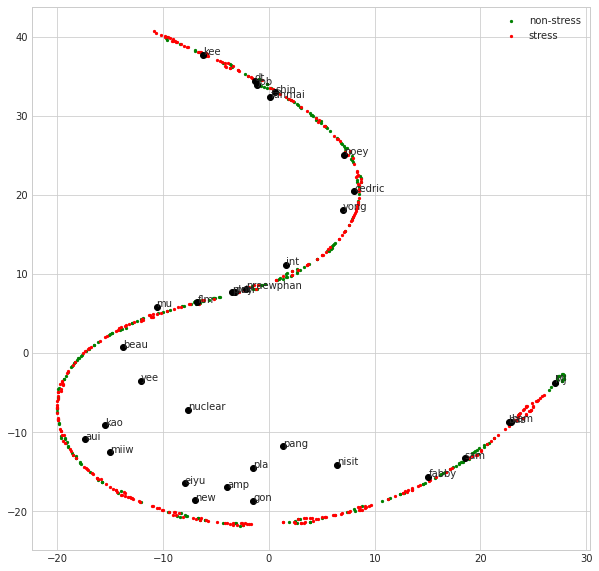

========== 2 ==========
SVM: 0.721875 0.71875 0.024206145913796356
LR: 0.69375 0.69375 0.05


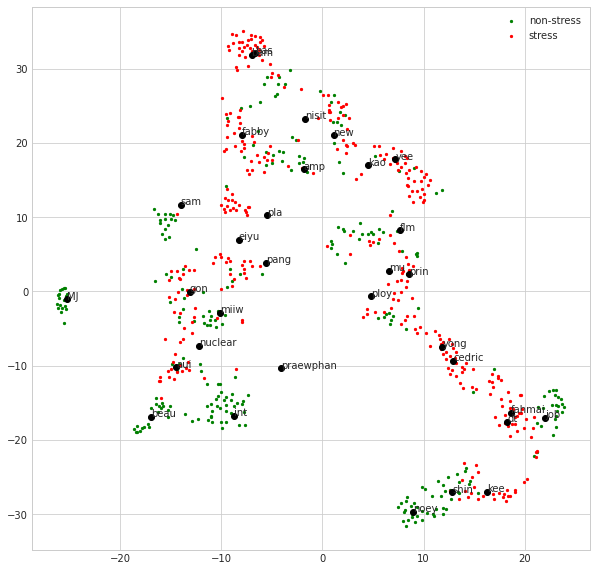

========== 3 ==========
SVM: 0.821875 0.81875 0.035078038001005694
LR: 0.8109375 0.8015625 0.041369382171480396


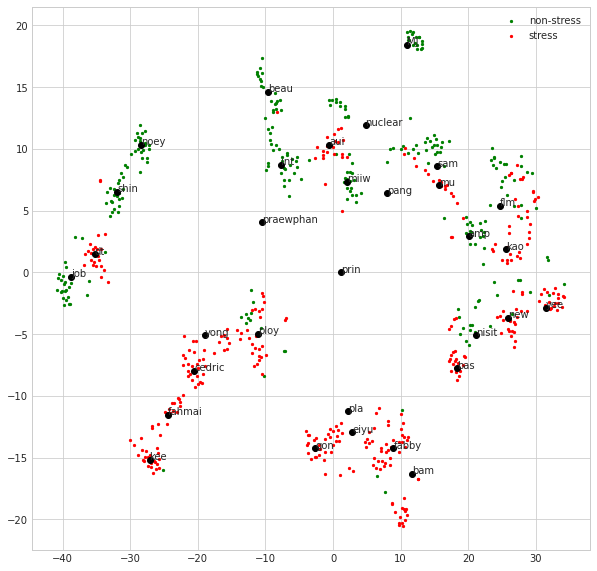

========== 4 ==========
SVM: 0.8328125 0.81875 0.05510997527671374
LR: 0.8125 0.8140625 0.039805435008928115


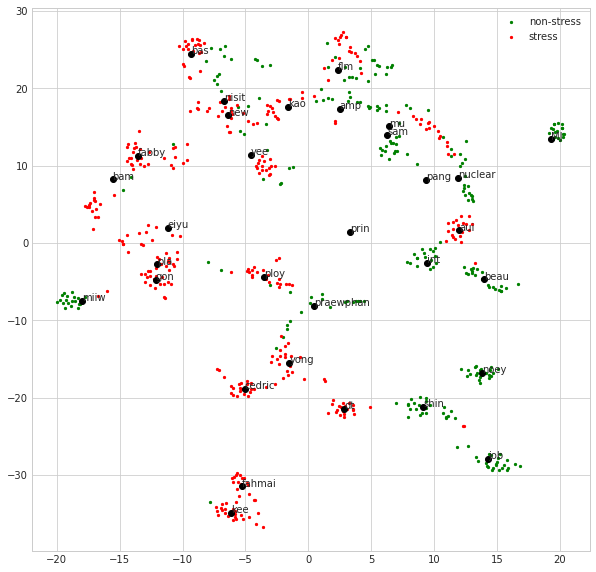

========== 5 ==========
SVM: 0.834375 0.8234375 0.04637756899892447
LR: 0.815625 0.803125 0.057706829101935586


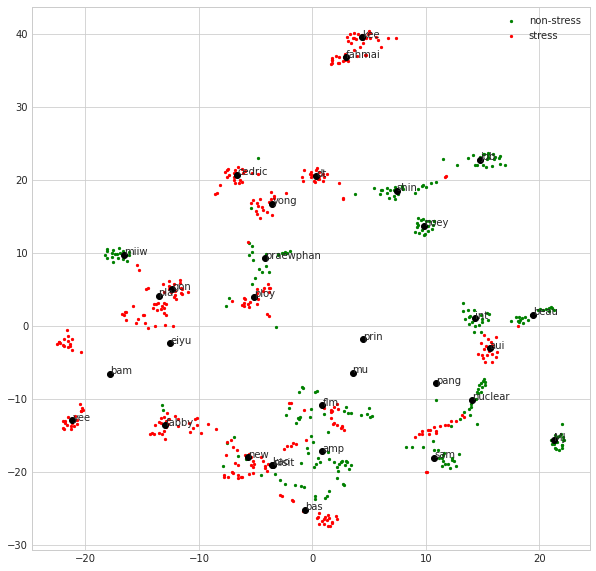

========== 6 ==========
SVM: 0.83125 0.8234375 0.041369382171480396
LR: 0.8171875 0.8140625 0.03159960690024482


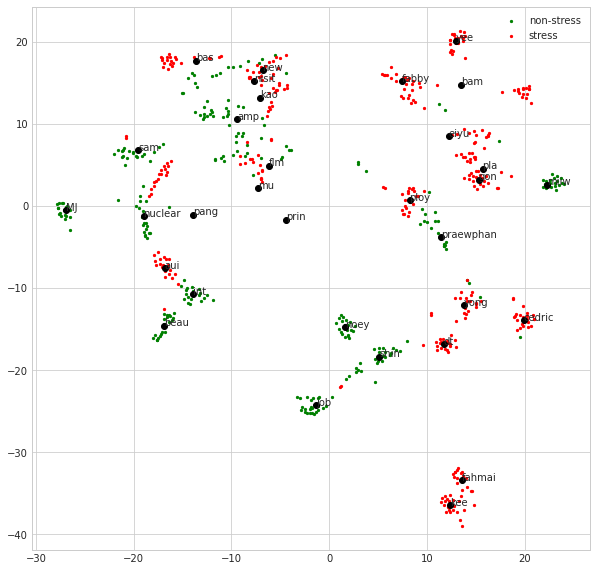

========== 7 ==========
SVM: 0.859375 0.8515625 0.0390625
LR: 0.7984375 0.7921875 0.04843750000000001


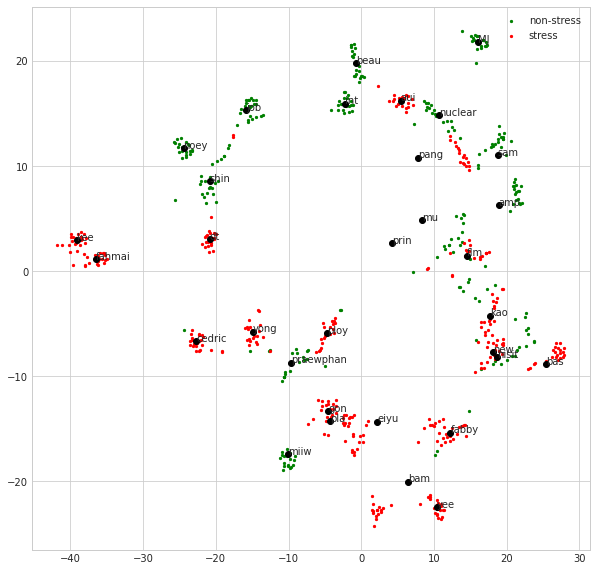

========== 8 ==========
SVM: 0.878125 0.86875 0.034374999999999996
LR: 0.7953125 0.7890625 0.03843241836327763


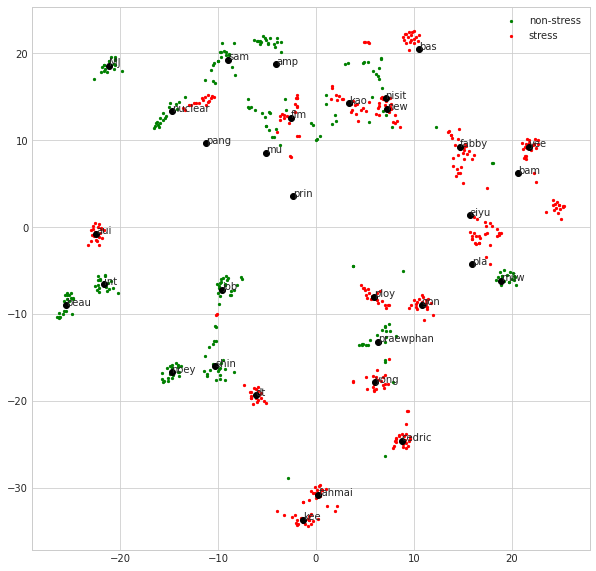

========== 9 ==========
SVM: 0.8859375 0.875 0.037629983058725926
LR: 0.7921875 0.784375 0.042961647140211


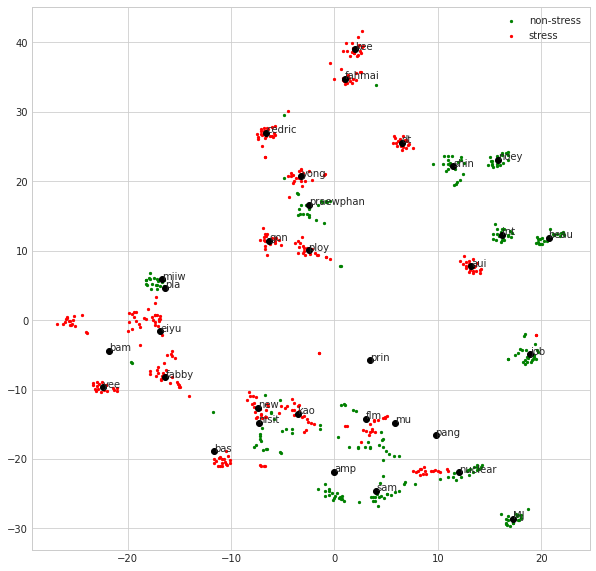

========== 10 ==========
SVM: 0.8875 0.8828125 0.027287889369645282
LR: 0.8 0.790625 0.03903123748998999


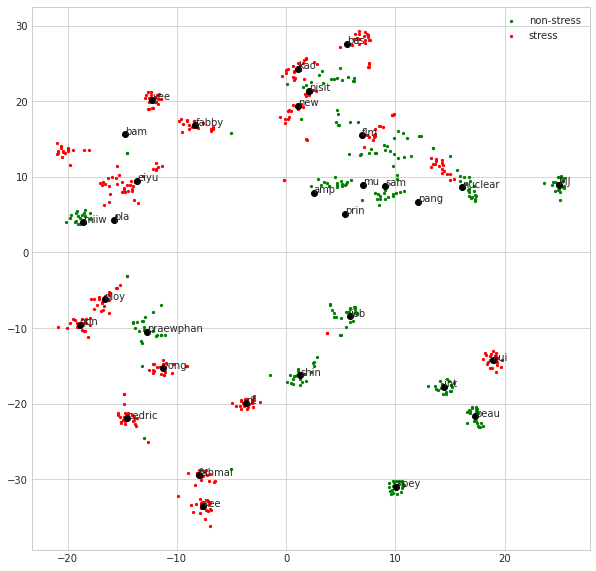

========== 11 ==========
SVM: 0.8875 0.8796875 0.04195537994405485
LR: 0.8 0.7875 0.051916399143237965


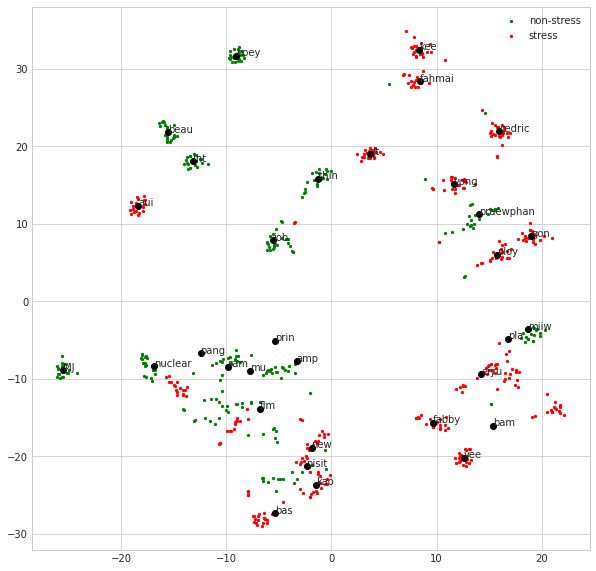

========== 12 ==========
SVM: 0.8953125 0.878125 0.046770717334674264
LR: 0.8109375 0.7984375 0.06306386272065802


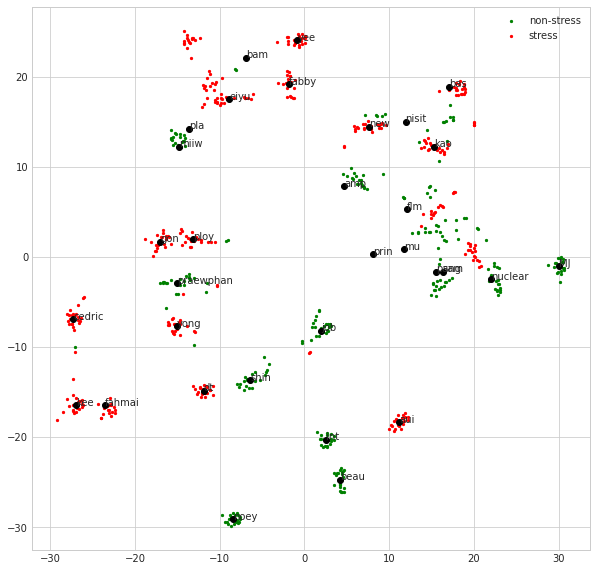

========== 13 ==========
SVM: 0.9 0.8890625 0.04444207079164966
LR: 0.81875 0.8 0.030297999108852055


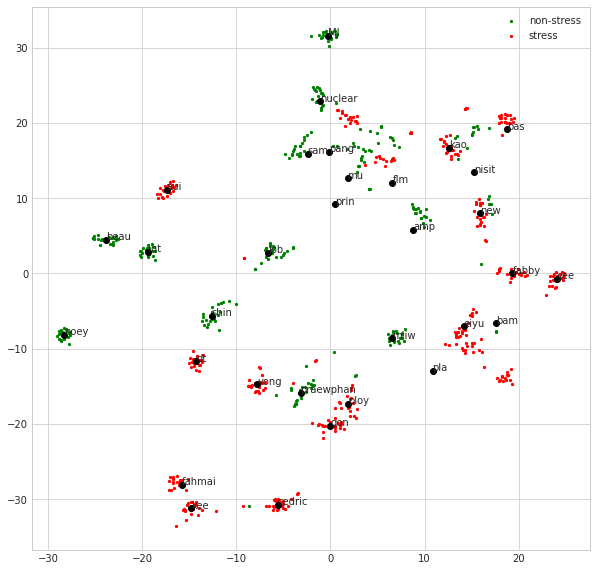

========== 14 ==========
SVM: 0.9 0.8875 0.0375
LR: 0.8390625 0.828125 0.0489139870078079


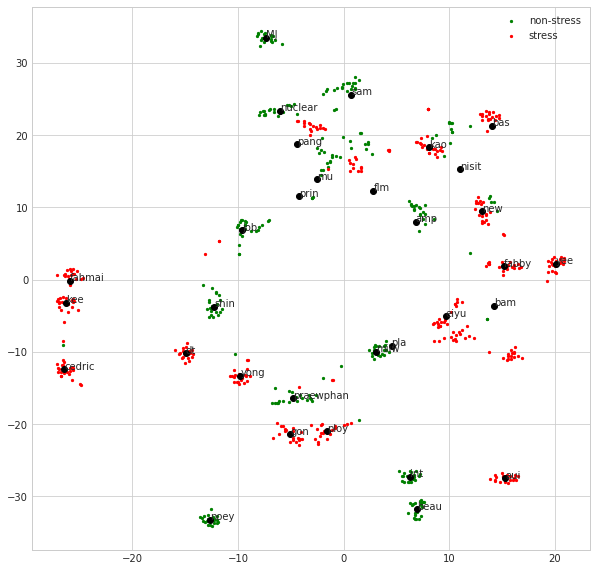

========== 15 ==========
SVM: 0.9 0.8875 0.040019526483955306
LR: 0.8375 0.8328125 0.05277920548142043


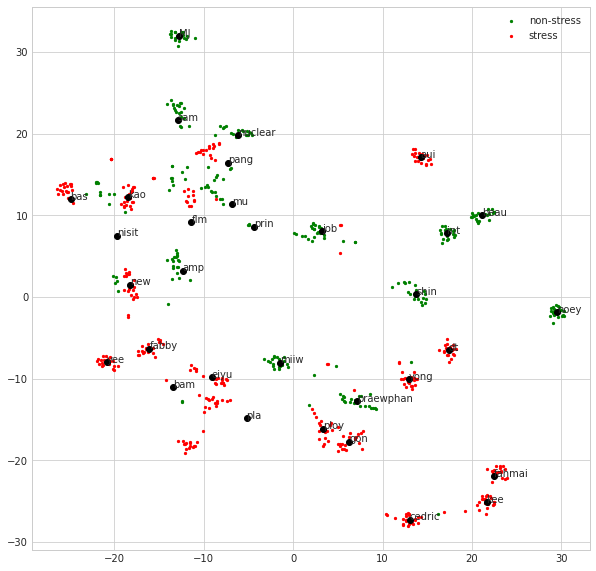

========== 16 ==========
SVM: 0.896875 0.8875 0.026882266459508208
LR: 0.846875 0.8328125 0.039559340316163004


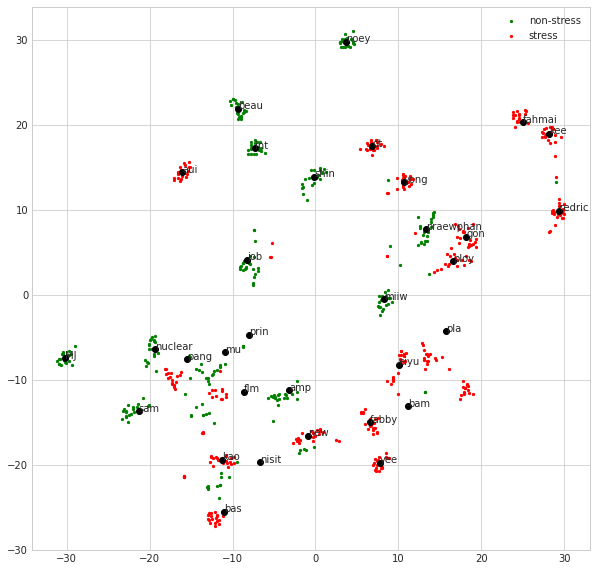

========== 17 ==========
SVM: 0.896875 0.89375 0.028641098093473996
LR: 0.846875 0.83125 0.047803307939932364


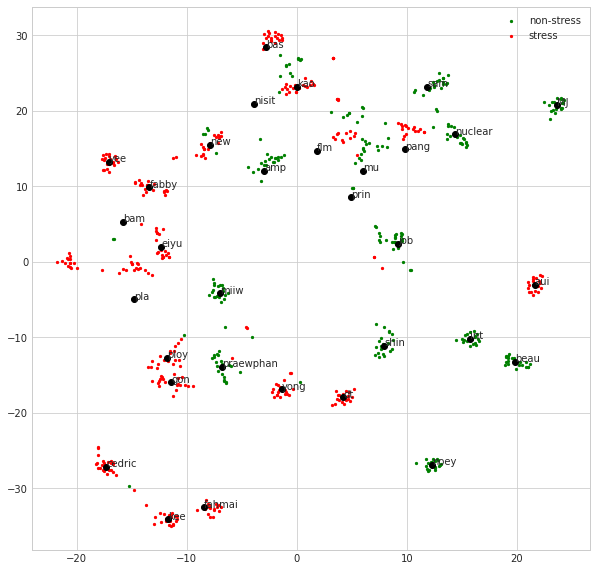

========== 18 ==========
SVM: 0.896875 0.890625 0.03890593624371479
LR: 0.846875 0.83125 0.041221581119602876


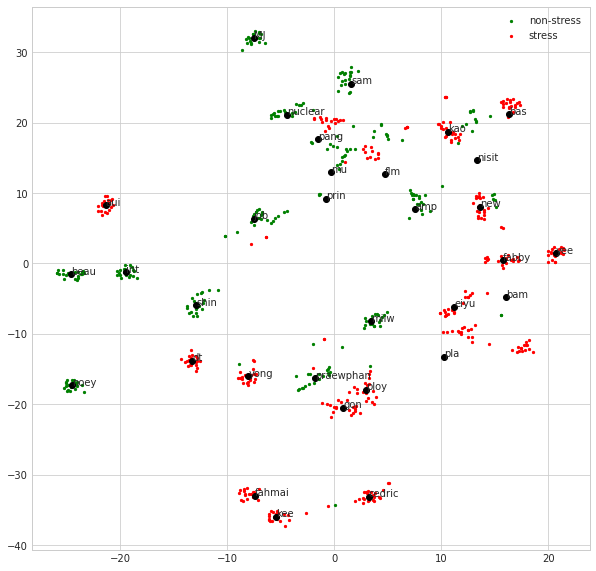

========== 19 ==========
SVM: 0.896875 0.890625 0.04014135180832853
LR: 0.846875 0.8375 0.03365728004459065


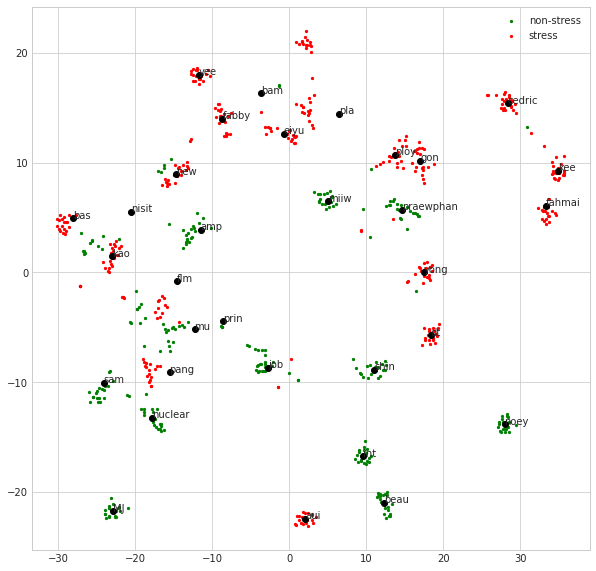

In [43]:
from sklearn.manifold import TSNE
for i in range(1,20):
    X = X_ori[:,:i].copy()
    y = y_ori.copy()
    print("="*10,i,"="*10)
    model, acc, cross = train_model_SVM(X,y,do_print=False)
    print("SVM:", acc, cross.mean(), cross.std())

    model, acc, cross = train_model_LR(X,y,do_print=False)
    print("LR:",acc, cross.mean(), cross.std())

    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
    fig,ax = plt.subplots(figsize = (10,10))
    cdict = {0: 'green', 1: 'red'}
    ldict = {0: 'non-stress', 1: 'stress'}
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(X_embedded[ix,0], X_embedded[ix,1], c =cdict[g], label = ldict[g], s = 5)

    for name in list(set(names)):
        point = X_embedded[names == name].mean(axis=0)
        ax.scatter(point[0],point[1], c='black')
        ax.text(point[0],point[1], s=name)
    ax.legend()
    plt.show()